# Error Profile: varying the signature length.

### 1. Introduction

This notebooks compares the **error** behaviour of the Bloom and Quotient Filter as the number of hash bits for each filter is varied.
Both filters are designed for _approximate set membership_ queries and have the property that, upon querying for the membership of an element:
1. Quering any item inserted into the sketch will always return `true` and **never** return `false` -- _"no false negative property"._
2. Some items that were not in the set used to build the filter **may** return `true` --  this is known as a _false positive_.

The **false positive probability (fpr)** is the probability that the filter returns `true` to any query item not in the set used to build the filter.  We test this by building a filter $S$ over a fixed input cardinality $n$ and then generating a query set $X$ that has empty intersection with the input set.  For every item in $X$, we count the number of times that the filter returns `true` to the approximate membership query and divide this by $|X|$. Over large enough sets $X$ and multiple independent trials, this should estimate the theoretical false positive probability of the filter.
For each filter, a signature is generated and the number of hash bits is the length of the signature.
The experiment is repeated over different signature lengths and the performance is compared to the theoretically expected curves.

## 2. Types of Filter

### 2.1 Bloom Filter ###

A **Bloom Filter** is an array of $m$ bits.  The array is populated using $k$ independent hash functions and the signature is the tuple of index locations in the array 
$h(x) = (h_1(x), h_2(x), \dots, h_k(x))$ with each $h_j(x) \in \{0, 1, 2, \dots, m-1 \}$.
Bloom filter accepts $n < m$ items with the specific $n$ coupled to both the length $m$ and the number of hash functions, $k$.
The Bloom filter fpr is approximately $\epsilon = (1 - e^{-\frac{nk}{m}})^k$ which is minimised with the choice of $k = \ln(2) \frac{m}{n}$.

An optimally initialised Bloom filter has $k = \frac{m}{n} \ln(2)$ so that the **space** in bits is $m = \frac{k}{\ln(2) n}$ and the **false positive probability** is approximately:
\begin{align}
\epsilon &\approx (1 - e^{\frac{n}{m}k})^k \\ 
&=(1 - e^{\frac{n}{m}\frac{m}{n} \ln(2)})^{\frac{m}{n} \ln(2)} \\ 
&= 2^{-\frac{m}{n} \ln(2)} \tag{*}  \\ 
&= 2^{-k}.
\end{align}

### 2.2 Quotient Filter ###

A **Quotient Filter** is an array of $k=2^Q$ slots, with each slot storing $b = 3 + f$ bits in total: $3$ bits are used for state and
a further $f$ bits are used for a fingerprint that partially identifies the item in a given slot.
We think of the fingerprint length, $f$, as being the signature length as it is this portion of a hash function output that 
is related to the accuracy of a generated filter.
To generate a fingerprint, we take a hash function $h(x)$ and use $Q$ of the hash bits to for the slot selection and $f$ of them for the fingerprint 
selection. 
Any further hash bits may be discarded and the total *space** usage in bits is $m = 2^Q(3+f)$.

The $Q$ slot bits are implicitly stored via the array index and any items that land in the same slot but have distinct fingerprints have their 
collision resolved through the three metadata state bits.
The $Q$ bits used for the address space represent a value for each item that refers to its _canonical slot_ -- the location an item would be stored were 
there no hash collisions.
Collisions are resolved similarly to linear probing with the combination of state and fingerprint bits being used to disambiguate items.
The Quotient Filter can, conceptually, accept up to $n = 2^Q$ items, however, this would cause complete saturation of the filter so isn't practical.  
Rather,  a **load factor**, $\alpha$, threshold between zero and one is chosen and only this fraction of the slots are used which acts as a bound on the maximum number of items that can be inserted into the sketch so that $\alpha \le \frac{n}{k}$.

A false positive is obtained if an unseen element hashes to a slot that is canonical for a previously seen element and has a matching fingerprint in the correct location.
The probability of the former event, assuming that $n$ items have been inserted, is at most $\alpha$ while the probability for the latter
The false positive rate using $r$ bit fingerprints is approximately:
\begin{align*}
\epsilon &\approx \alpha 2^{-r}.
\end{align*}

## 2. Results

First we show the theoretical type of tradeoff that we hope to find in the characterisation profiles.
For both filters, we expect the false positive rate to exponentially decrease with the number of hash bits used.

In [2]:
import numpy as np
import pandas as pd     
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from typing import Tuple
%matplotlib inline
plt.rcParams['font.size'] = 14

Text(0.5, 1.0, 'False positive rate vs. Number of hash bits')

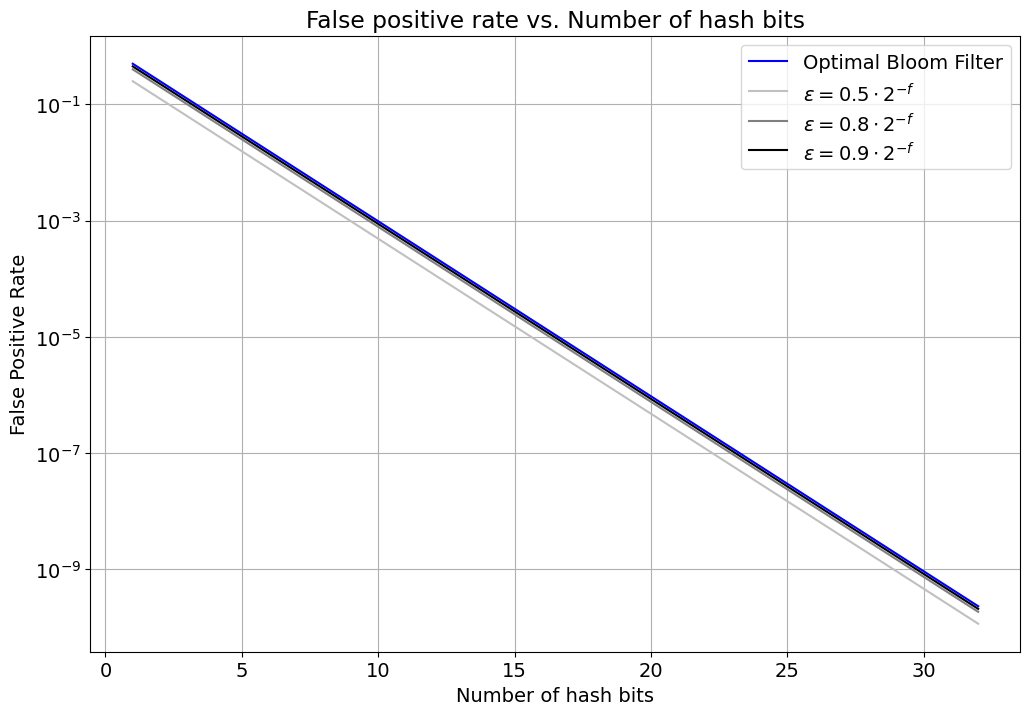

In [4]:
num_hash_bits = np.arange(1,33)


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(num_hash_bits, 2.**(-num_hash_bits), label="Optimal Bloom Filter", color="blue") 

colours = ["silver", "grey", "black"]
for i, alpha in enumerate([0.5, 0.8, 0.9]):
    theory_str = "$\epsilon_{{}} = {} \cdot 2^{{-f}}$".format(alpha, alpha)
    ax.plot(num_hash_bits, alpha*2.**(-num_hash_bits), label=theory_str, color=colours[i])
ax.grid()
ax.set_yscale("log")
ax.legend()
ax.set_xlabel(r"Number of hash bits")
ax.set_ylabel("False Positive Rate")
ax.set_title("False positive rate vs. Number of hash bits")
#fig.savefig("false-positive-rates.pdf")

Note that for a _fixed_ bitmap length and input size, simply increasing the number of hash functions in the Bloom Filter does not improve performance.
When the number of hash functions increases, there is competing behaviour: on the one hand, more bits are set which can increase the number of false positives reported.
On the other hand, a false positive is triggered only when all of the bit positions are set, so using more hash functions means that the requirement is higher.
In contrast, because the false positive probability of a Quotient Filter is only related to the fingerprint length (rather than also the number of items inserted), increasing
the length of the fingerprint yields a monotonically decreasing false positive rate.
We can see this feature in the following plot.

(5e-06, 2.3405078559743058)

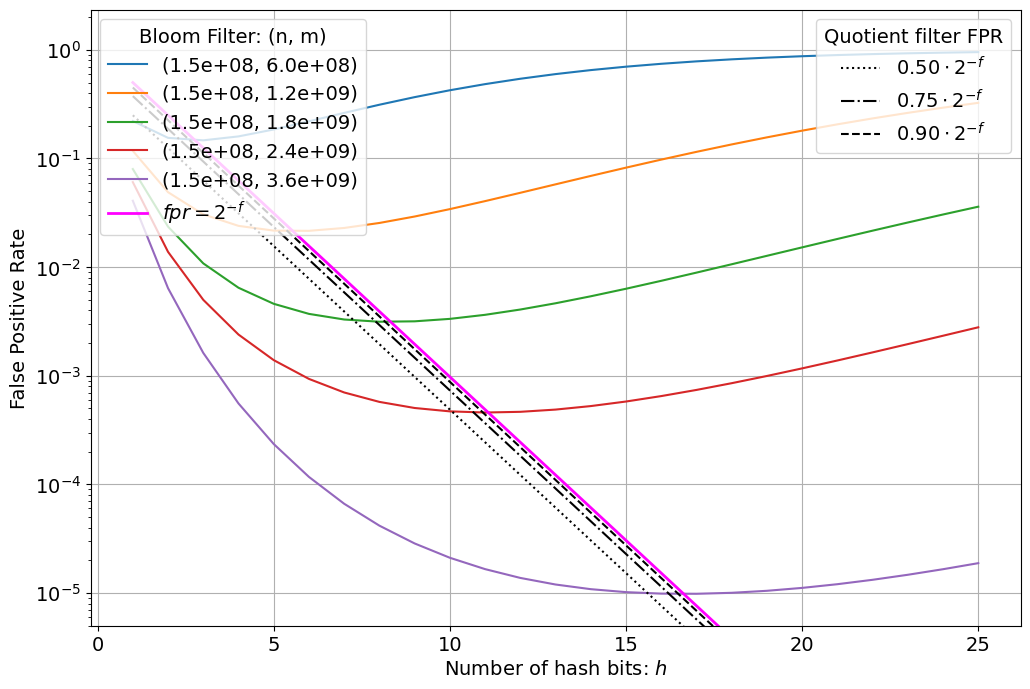

In [6]:
ns = [1.5E8]
ms = [4, 8, 12, 16, 24]
ks = np.arange(1, 26)


fig, ax = plt.subplots(figsize=(12, 8))


# bloom plots 
bf_lines = []
for n in ns:
    for r in ms:
        m = r*n
        bf_l, = ax.plot(ks, (1. - np.exp(-ks*n / m))**ks, label=f"({n:.1e}, {m:.1e})")
        bf_lines.append(bf_l)
opt_bf_l, = ax.plot(ks, 2.**(-ks), label=r"${fpr} = 2^{-f}$", color="magenta", linewidth=2)
bf_lines.append(opt_bf_l)
bf_legend = ax.legend(title="Bloom Filter: (n, m)", handles=bf_lines, loc="upper left")
ax.add_artist(bf_legend)

# quotient plots
qf_lines = []
linestyles = [":", "-.", "--"]
for ii, alpha in enumerate([0.5, 0.75, 0.9]):
    qf_l, = ax.plot(ks, alpha*2.**(-ks), label=f"${alpha:.2f} \cdot 2^{{-f}}$", linestyle=linestyles[ii], color="black")
    qf_lines.append(qf_l)

qf_legend = ax.legend(handles=qf_lines, title="Quotient filter FPR", loc="upper right")

ax.set_xlabel(r"Number of hash bits: $h$")
ax.set_ylabel("False Positive Rate")
ax.set_yscale("log")
ax.grid()

ax.set_ylim(bottom=5e-6)
#fig.savefig("image/fpr-vs-numh.pdf")

Depending on the parameter setting, miscalibrating the Bloom filter parameters can lead to sharper changes in error performance.

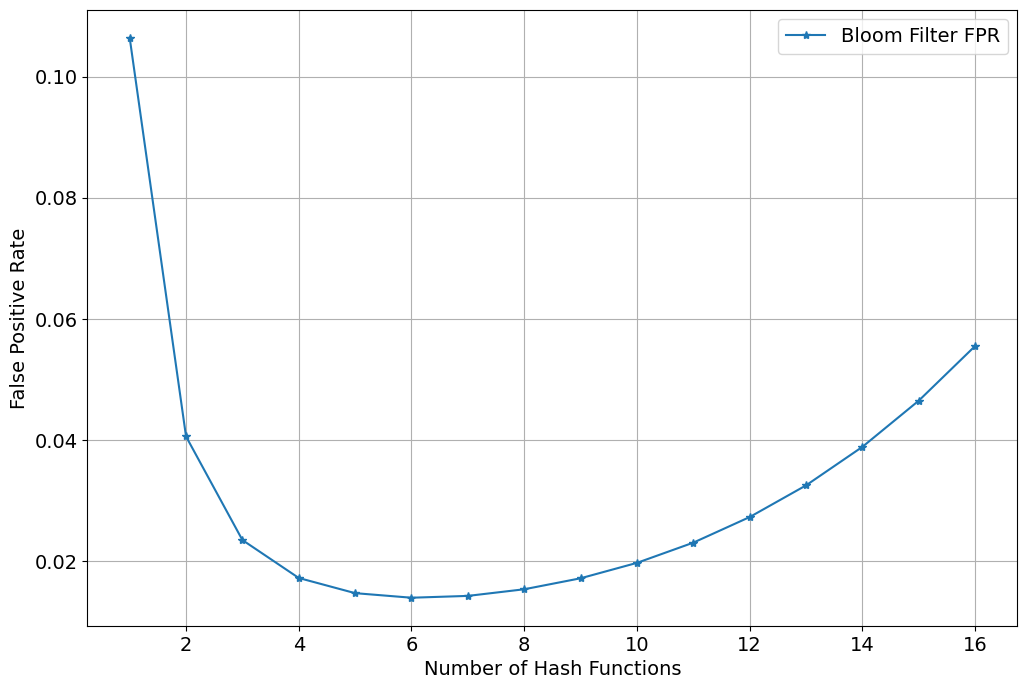

In [7]:
n = int(0.9*(1<<25)) # chosen for illustration
m = 1<<28
ks = np.arange(1, 17)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ks, (1. - np.exp(-ks*n / m))**ks, label="Bloom Filter FPR", marker="*")
ax.set_xlabel("Number of Hash Functions")
ax.set_ylabel("False Positive Rate")
ax.grid()
ax.legend()

### Experiment 1. Validating the theoretical performance.

In this plot we demonstrate that the expected behaviour above is borne out in practice.

The experimental configuration can be found at the bottom of the input result file and in this case is as follows.
Set the input cardinality to $n = 0.8 * 2^20$; vary the number of hash bits from a lower to an upper bound and use the number of hash bits to determine the number of trials at each hash bit value; 
for the Bloom filter, use these parameters to determine an optimal filter and for the Quotient filter just use the number of hash bits as the fingerprint length.

In [24]:
def bloom_filter_fpr(n:int, k:int) -> float:
    """Returns the theoretical false positive rate of a Bloom filter with n elements, and k hash functions."""
    m = k * n
    m /= np.log(2.)
    m = int(m)
    return (1 - (1 - 1/m)**(k*n))**k

def quotient_filter_fpr(alpha: float, bits_per_entry: int) -> float:
    """
    Returns the theoretical false positive rate of a Quotient filter with alpha load factor that 
    uses `bits_per_entry` many bits for each entry added to the sketch.
    """
    return 2**(3 - alpha*bits_per_entry)

from scipy.stats import binom as binom_dist
def probability_sum(num_slots:int, num_elements:int, fingerprint_length:int) -> float:
    """
    The vectorized part of this code more efficiently evaluates 
    for k in range(m+1):
        probs[k] = dist.pmf(k)
        probs[k] *= (1. - (1. - 2.**(-f))**k)

    This sum is well approximated by alpha*2^(-f) for alpha = n / m
    """
    m = num_slots
    n = num_elements
    f = fingerprint_length
    assert isinstance(m, int), "num_slots must be an integer"
    assert isinstance(n, int), "num_elements must be an integer"
    assert isinstance(f, int), "fingerprint_length must be an integer"
    dist = binom_dist(n, 1./m)
    probs = dist.pmf(np.arange(m+1))
    probs *= (1. - (1. - 2.**(-f))**np.arange(m+1))
    return np.sum(probs)

n = int(0.9 * 2**20)
theoretical_bloom_results = [] 
theoretical_quotient_results = []
num_test_bits = np.arange(4,25)

for k in num_test_bits:
    theoretical_bloom_results.append([k, k/np.log(2), bloom_filter_fpr(n, k)])
    theoretical_quotient_results.append([k, k, quotient_filter_fpr(0.9, k)])


bloom_theory_accuracy = pd.DataFrame(theoretical_bloom_results, columns=['k', 'bitsPerEntry', 'FPR'])
quotient_theory_accuracy = pd.DataFrame(theoretical_quotient_results, columns=['k', 'bitsPerEntry', 'FPR'])

In [18]:
def parse_accuracy_results(filename:str) -> Tuple[pd.DataFrame, float, int]:
    """
    Takes an input file name in .txt format, strips out the extra strings and returns 
    the main results in a dataframe.

    The universe size is the largest power of 2 that is used to insert into the sketch and 
    the capacity is how far along the power of two interval used for maximum cardinality.

    Eg. capacity = 0.9 and lgU = 20 means that we insert 0.9 * 2^20 elements into the sketch.
    """
    with open(filename) as f:
        lines = f.readlines()[2:]
    ignore_from_idx = lines.index("PROPERTIES:\n")
    results = lines[:ignore_from_idx-1] # there is an empty line preceding the ignore_from_idx
    results_clean = [r.strip("\n") for r in results]
    results_df = pd.DataFrame(sub.split("\t") for sub in results_clean[1:])
    results_df.columns = results_clean[0].split("\t")
    for col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col])

    # get the universe size and capacity 
    properties = lines[ignore_from_idx:]
    properties_clean = [p.strip("\n") for p in properties]
    strings_to_find = ['Universe_capacity', 'Universe_lgU']
    found_strings = [s for s in properties_clean if any(substring in s for substring in strings_to_find)]
    values = [float(s.split('=')[1]) for s in found_strings]
    capacity = values[0]
    lgU = int(values[1])
    return results_df, capacity, lgU

In [19]:
bloom_results_df, bloom_thld, bloom_lgU = parse_accuracy_results("BloomFilterAccuracyProfile20240612_050335PST.txt")
quotient_results_df, q90, _ = parse_accuracy_results("QuotientFilterAccuracyProfile20240617_065441PST.txt")
quotient_results_df_75, q75, _ = parse_accuracy_results("QuotientFilterAccuracyProfile20240612_062110PST.txt")
m = 2**20
q_alpha = 0.9
q_n = int(q_alpha*m)

In [11]:
bloom_lgU

20

In [20]:
combined_df = pd.merge(bloom_results_df, quotient_results_df, on="numHashes", suffixes=("_bloom", "_quotient"))
combined_df.drop(["numQueryPoints_bloom", "numQueryPoints_quotient", "numTrials_bloom", "numTrials_quotient"], axis=1, inplace=True)
combined_df.tail(15)

,numHashes,bitsPerEntry_bloom,FPR_bloom,filterSizeBits_bloom,bitsPerEntry_quotient,FPR_quotient,filterSizeBits_quotient
6,10,14,1.016590e-03,13614976,10,7.020040e-03,10485760
7,11,15,4.788000e-04,14976512,11,3.261530e-03,11534336
8,12,17,2.345400e-04,16337984,12,1.752870e-03,12582912
9,13,18,1.299970e-04,17699520,13,8.584560e-04,13631488
10,14,20,5.921320e-05,19060992,14,4.600410e-04,14680064
11,15,21,2.975460e-05,20422464,15,2.182010e-04,15728640
12,16,23,1.885760e-05,21784000,16,1.101220e-04,16777216
13,17,24,7.708870e-06,23145472,17,5.435940e-05,17825792
14,18,25,3.326770e-06,24507008,18,2.869890e-05,18874368
15,19,27,2.005160e-06,25868480,19,1.393830e-05,19922944


In [14]:
quotient_results_df["fingerprintLength"] = quotient_results_df["numHashes"] - 3
quotient_results_df["theoreticalFPR"] = 2.**(-quotient_results_df["fingerprintLength"])
quotient_results_df["scaledFPR"] = 0.9*2.**(-quotient_results_df["fingerprintLength"])
quotient_results_df["exactCalcFPR"] = pd.Series([probability_sum(m, q_n, f) for f in quotient_results_df["fingerprintLength"]])

quotient_results_df

,numHashes,bitsPerEntry,FPR,filterSizeBits,numQueryPoints,numTrials,fingerprintLength,theoreticalFPR,scaledFPR,exactCalcFPR
0,4,4,3.590670e-01,4194304,32,608,1,5.000000e-01,4.500000e-01,3.623718e-01
1,5,5,2.019490e-01,5242880,64,412,2,2.500000e-01,2.250000e-01,2.014837e-01
2,6,6,1.035220e-01,6291456,128,299,3,1.250000e-01,1.125000e-01,1.064026e-01
3,7,7,5.340250e-02,7340032,256,228,4,6.250000e-02,5.625000e-02,5.469720e-02
4,8,8,2.748400e-02,8388608,512,181,5,3.125000e-02,2.812500e-02,2.773316e-02
5,9,9,1.373830e-02,9437184,1024,147,6,1.562500e-02,1.406250e-02,1.396408e-02
6,10,10,7.020040e-03,10485760,2048,122,7,7.812500e-03,7.031250e-03,7.006586e-03
7,11,11,3.261530e-03,11534336,4096,103,8,3.906250e-03,3.515625e-03,3.509451e-03
8,12,12,1.752870e-03,12582912,8192,89,9,1.953125e-03,1.757813e-03,1.756268e-03
9,13,13,8.584560e-04,13631488,16384,77,10,9.765625e-04,8.789063e-04,8.785198e-04


In [15]:
for q in [q90, q75]:
    q_n = int(q*m)
    quotient_results_df_75["fingerprintLength"] = quotient_results_df_75["numHashes"] - 3
    quotient_results_df_75["theoreticalFPR"] = 2.**(-quotient_results_df_75["fingerprintLength"])
    quotient_results_df_75["exactCalcFPR"] = pd.Series([probability_sum(m, q_n, f) for f in quotient_results_df_75["fingerprintLength"]])

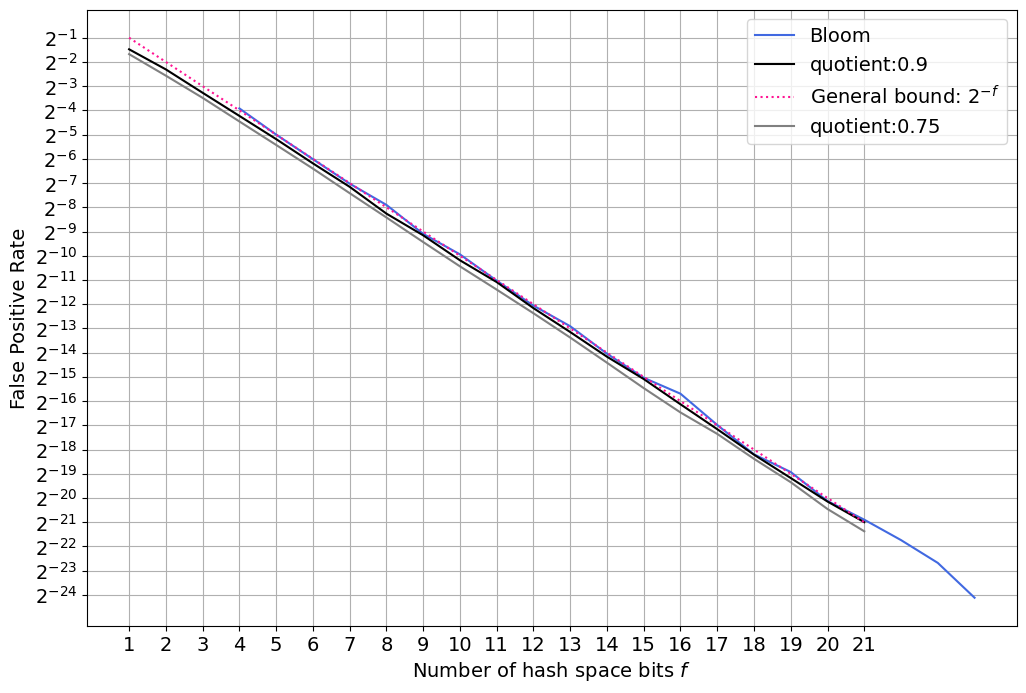

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(bloom_results_df["numHashes"], bloom_results_df["FPR"], label="Bloom", color="royalblue")

ax.plot(quotient_results_df["fingerprintLength"], quotient_results_df["FPR"], label="quotient:0.9", color="black")
ax.plot(quotient_results_df["fingerprintLength"], 2.**(-quotient_results_df["fingerprintLength"]), label="General bound: $2^{-f}$", color="deeppink", linestyle=":")


ax.plot(quotient_results_df_75["fingerprintLength"], quotient_results_df_75["FPR"], label="quotient:0.75", color="grey")
ax.grid()
ax.set_yscale("log", base=2)
ax.legend()
ax.set_xticks(quotient_results_df["fingerprintLength"])
ax.set_yticks([2.**(-j) for j in range(1,25)])
ax.set_xlabel("Number of hash space bits $f$")
ax.set_ylabel("False Positive Rate")
fig.savefig("image/accuracy-vs-num-hashes.pdf")

Both error rates roughly follow the curve $2^{-f}$.  This means that increasing the number of hash bits space by one reduces the false positive rate by a factor of two.  The false positive rate of the Quotient filter is slightly smaller when it is less-densely filled.  

We can also explore the space efficiency: namely the number of bits used per element added to the filter.  We see that for lower accuracy (high fpr) regimes, the Bloom filter is more efficient, 
while the converse is true for higher accuracy (low fpr) regimes.

Text(0.5, 0, 'Number of hash space bits $f$')

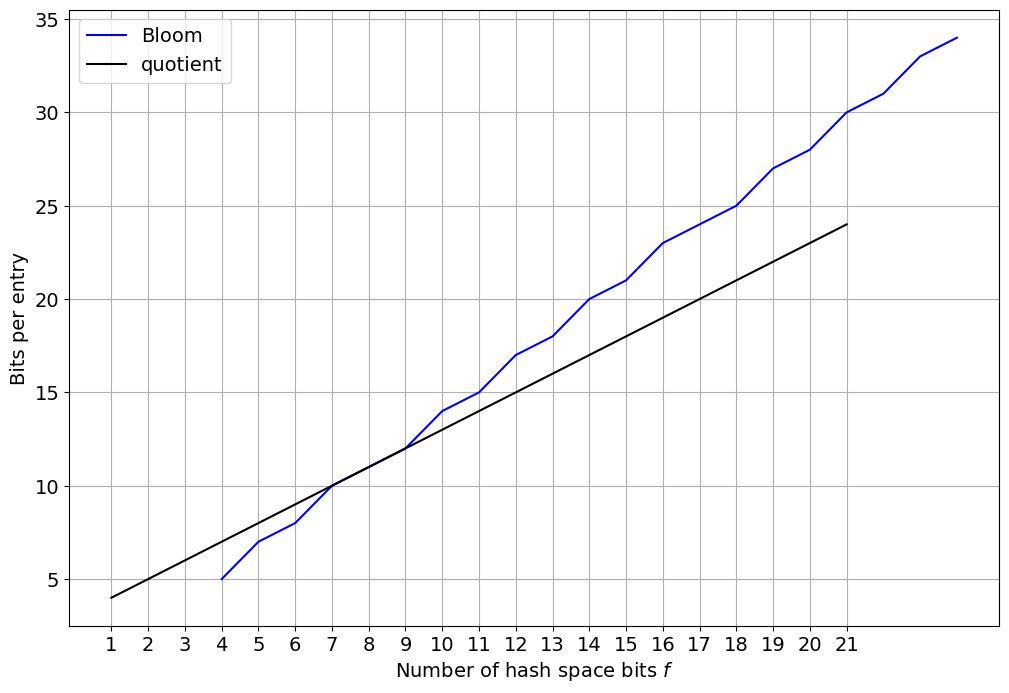

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(bloom_results_df["numHashes"], bloom_results_df["bitsPerEntry"], label="Bloom", color="blue")
ax.plot(quotient_results_df["fingerprintLength"], quotient_results_df["bitsPerEntry"], label="quotient", color="black")
ax.grid()
ax.legend()
ax.set_xticks(quotient_results_df["fingerprintLength"])
ax.set_ylabel("Bits per entry")
ax.set_xlabel("Number of hash space bits $f$")

Text(0, 0.5, 'False Positive Rate')

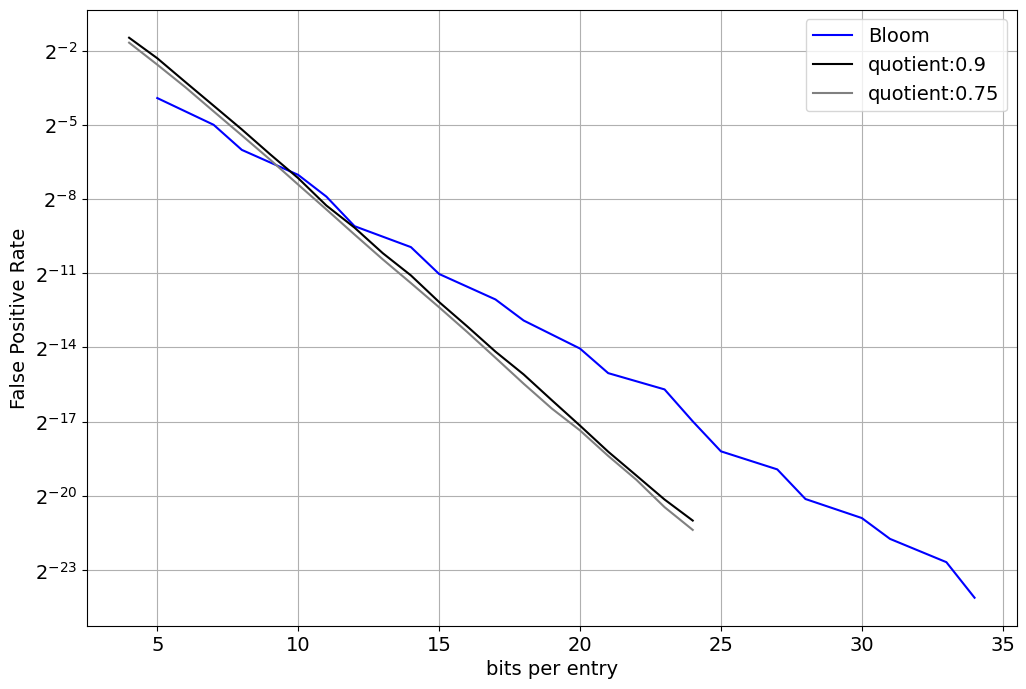

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(bloom_results_df["bitsPerEntry"], bloom_results_df["FPR"], label="Bloom", color="blue")

ax.plot(quotient_results_df["bitsPerEntry"], quotient_results_df["FPR"], label="quotient:0.9", color="black")
ax.plot(quotient_results_df_75["bitsPerEntry"], quotient_results_df_75["FPR"], label="quotient:0.75", color="grey")
ax.grid()
ax.set_yscale("log", base=2)
ax.legend()
ax.set_xlabel("bits per entry")
ax.set_ylabel("False Positive Rate")

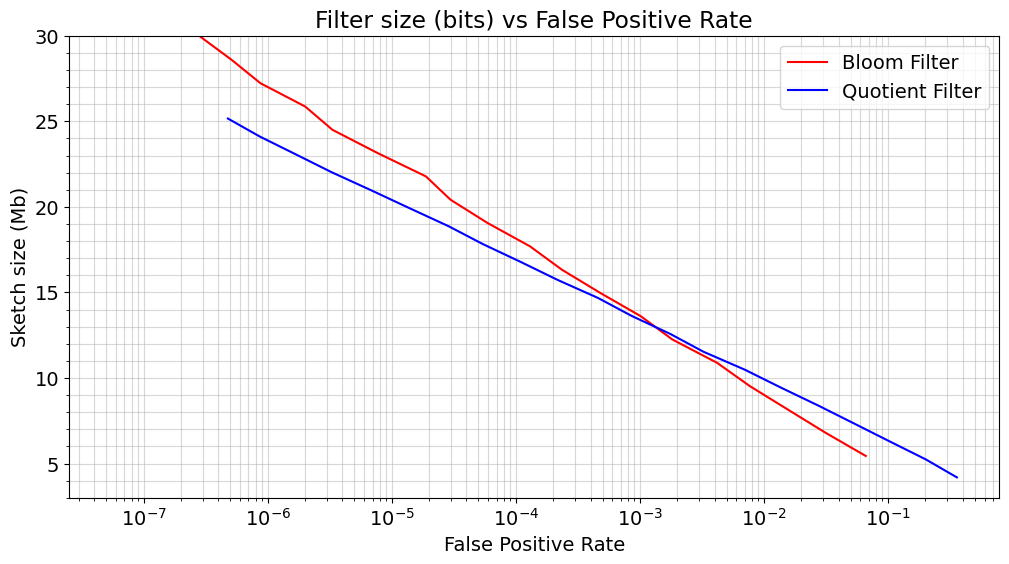

In [99]:
fig, ax = plt.subplots(figsize=(12,6))


NRML_CNST = 1E6 
ax.plot(bloom_results_df["FPR"], bloom_results_df["filterSizeBits"]/NRML_CNST,
        label="Bloom Filter", color="red", linestyle="-")
ax.plot(quotient_results_df["FPR"], quotient_results_df["filterSizeBits"]/NRML_CNST,
        label="Quotient Filter", color="blue", linestyle="-")


ax.legend()
#ax.set_yscale("log", base=2)
ax.set_xscale("log", base=10)
ax.set_ylabel("Sketch size (Mb)")
ax.set_xlabel("False Positive Rate")

ax.set_ylim(3,30)
ax.set_title("Filter size (bits) vs False Positive Rate")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="both", alpha=0.5)

Consistent with the prior plots, we see that the there are two regions of behaviour.  
We control the false positive rate for both filters, using an optimally-configured Bloom filter and a quotient filter with the number of fingerprints that achieves the fixed FPR.  For large false positive rates, a Bloom filter is smaller than Quotient filter.  However, if a smaller false positive rate is desired, then a Quotient filter has a lower space footprint.

## References
<a id="1">[1]</a> 
Bender, Michael A., et al. "Don't thrash: How to cache your hash on flash." 3rd Workshop on Hot Topics in Storage and File Systems (HotStorage 11). 2011.